# Automated essay scoring system

- Author: Joaquin Farina
- Date: December, 2022

## Description

Understanding the issues and advantages of Automated Essay Scoring Systems (AES) for learners of  English as a second language can foster innovation through the development of new solutions and applications. To stimulate more effective English learning, AES can be an efficient tool for assisting teachers in low-stake classroom assessment, as well as rating procedures for larger standardized tests. For this assignment, I develop a supervised machine learning algorithm that can accurately predict proficiency levels low, medium, or high, written by TOEFL test takers.

## Resources 
- [Data](https://drive.google.com/file/d/1eATrCCQBZJrD0QpHwN90THBR4qDwMrND/view?usp=share_link)
- [Poster](https://drive.google.com/file/d/1174FnIZjuwbKX3dyDzLSh-B0kLWHeR3b/view?usp=share_link)

# Set up

In [ ]:
!pip install spellchecker
!pip install pyspellchecker
!pip install pointofview
!python -m spacy download en_core_web_md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.9 MB 4.3 MB/s 
  Created wheel for spellchecker: filename=spellchecker-0.4-py3-none-any.whl size=3966514 sha256=907979cc5b50971d4ae446a0aa98e7de1cc09119b1cb78fafa8adc1edef16b5b
  Stored in directory: /root/.cache/pip/wheels/f5/e3/fd/9d49c61c34dd99995c2d38f6b94fd33bfa7a559e3bfd8f3041
  Created wheel for inexactsearch: filename=inexactsearch-1.0.2-py3-none-any.whl size=7140 sha256=f5ec543a09a195fd38e60e42de840bb7e1fdaa0cf1180e95ffaca421e2dcde20
  Stored in directory: /root/.cache/pip/wheels/11/c0/e2/2475e4b2981445a2a1f469c7a88ff3e4f1ce7acc6281e56033
  Created wheel for silpa-common: filename=silpa_common-0.3-py3-none-any.whl size=8481 sha256=5ad16f7054745591a86a3b5c7f3146ad02a37fa4bded5bd9a1f35ad7995f6a32
  Stored in directory: /root/.cache/pip/wheels/c7/a5/67/816bbc59aef9be86b1d58f1db723f8b5896ee9605ea0603b5b
  Created wheel for soundex: filename=s

In [ ]:
import pandas as pd 
from sympy import symbols,Eq, solve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import nltk
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import numpy as np
from spellchecker import SpellChecker
import string
from sklearn.ensemble import RandomForestClassifier
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
import pointofview
import re
from spacy.matcher import Matcher
import math
import spacy
nlp = spacy.load("en_core_web_sm")
from ssl import SSL_ERROR_INVALID_ERROR_CODE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import imblearn
from imblearn.over_sampling import RandomOverSampler
import spacy
import random

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Load data

In [ ]:
# Load
data = pd.read_csv('ETS_corpus_F22.csv', usecols = ['label','text'])
# Rename target values
data.label.replace({'low':1,'medium':2, 'high':3}, inplace=True)

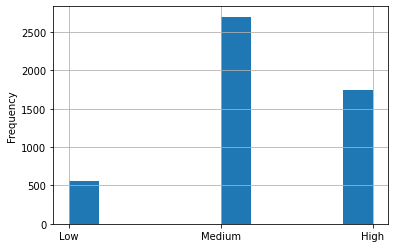

In [ ]:
# Histogram 
data.label.hist()
plt.xticks([1,2,3],['Low','Medium','High'])
plt.ylabel('Frequency')
plt.show()

# Preprocessing

In [ ]:
# 1. Expand contractions
def expand_contractions(text):
  # specific
  text = re.sub(r"won\'t", "will not", text)
  text = re.sub(r"can\'t", "can not", text)
  # general
  text = re.sub(r"n\'t", " not", text)
  text = re.sub(r"\'re", " are", text)
  text = re.sub(r"\'s", " is", text)
  text = re.sub(r"\'d", " would", text)
  text = re.sub(r"\'ll", " will", text)
  text = re.sub(r"\'t", " not", text)
  text = re.sub(r"\'ve", " have", text)
  text = re.sub(r"\'m", " am", text)
  return text
  
# apply
data['text'] = data['text'].apply(expand_contractions)

In [ ]:
# 2. Remove stopwords 
def no_stopwords(text):
  newText = ""
  for word in text.lower().split():
    if word not in stopwords:
      newText = newText + word + " "
  return newText
  
# apply
data['text_no_stopwords'] = data.text.apply(no_stopwords)

# Features

Linguistic features to be used for the predictive algorithm. 

## Main features

In [ ]:
# 1. Misspelled words 
def total_misspellings(text):
  text = re.sub(r'[^\w\s]', '', text)
  tokenized_text = re.findall("[a-zA-Z,.]+",text)
  spell = SpellChecker()
  misspelled = spell.unknown(tokenized_text)
  return len(misspelled)
  
# apply
data['n_misspellings'] = data.text.apply(total_misspellings)

In [ ]:
# 2. average and std word length 
def word_length(text):
  tokenized = text.split() 
  len_list = []
  for word in tokenized:
    len_list += [len(word)]
  return np.mean(len_list), np.std(len_list)

# apply 
data['mean_word_length'], data['std_word_length'] =  zip(*data.text_no_stopwords.map(word_length))

In [ ]:
# 3. number of paragraphs, and mean-std length 
def n_paragraphs(text):
  text_par = text.split('\n')
  text_par_final=[]
  for t in text_par:
    if len(t)>0:
      text_par_final +=[t]
  par_mean = np.mean([len(x) for x in text_par_final])
  par_std = np.std([len(x) for x in text_par_final])
  return len(text_par_final), par_mean, par_std

# apply
data['n_paragraphs'], data['mean_len_paragraphs'], data['std_len_paragraphs'] =  zip(*data.text.map(n_paragraphs))

In [ ]:
# 4. Point of view 
def POV(text):
  sentences = text.split('.')
  first = 0
  second = 0
  third = 0
  none = 0
  for sent in sentences: 
    POV = pointofview.get_text_pov(sent)
    if POV == 'first':
      first+=1
    elif POV == 'second':
      second+=1
    elif POV == 'third':
      third +=1
    else:
      none +=1
  tot = first +second+third+none 
  return first/tot,second/tot,third/tot,none/tot

# apply 
data['sent_1st_person'], data['sent_2nd_person'], data['sent_3rd_person'], data['sent_none_person'] =  zip(*data.text.map(POV))

In [ ]:
# 5. Similarity between paragraphs 
def paragraph_similarity(text):
  text_par = text.split('\n')
  n_par = len(text_par)
  sim_list = []
  for k in range(1,n_par):
    if (len(text_par[k-1])>0) & (len(text_par[k])>0):
      doc1 = nlp(text_par[k-1])
      doc2 = nlp(text_par[k])
      similarity = doc1.similarity(doc2)
      sim_list+=[similarity]
  sim_mean = np.mean(sim_list)
  sim_std = np.std(sim_list)
  return sim_mean, sim_std

# apply 
data['paragraph_similarity_mean'], data['paragraph_similarity_std'] =  zip(*data.text.map(paragraph_similarity))

<ipython-input-11-f56bcdf23d39>:10: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  similarity = doc1.similarity(doc2)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, d

## Additional features

In [ ]:
# 1. text length
data['text_length'] = data.text.apply(len)

# 2. number of tokens
def n_tokens(text):
  return len(text.split())
data['n_tokens'] = data.text.apply(n_tokens)

# 3. number of unique tokens
def n_types(text):
  return len(set(text.split()))
data['n_types'] = data.text.apply(n_types)

# 4. TTR
data['TTR'] = data.n_types/data.n_tokens

# 5. Number of words occurring once 
def no_duplicates(text): 
    word_count={} #Dictionary is used to store word frequencies. 
    ret_lst=[] #returning list
    lst=text.split()
    ct = 0
    for word in lst:
        if word not in word_count:
            word_count[word]=1
        else:
            word_count[word]=word_count[word]+1;

    for item in word_count.keys():
        if word_count[item] == 1:
          if item not in ret_lst:
                ret_lst.append(item)
                ct = ct + 1
    return ct
data['n_words_once'] = data.text.apply(no_duplicates)

# 6. VOCD 
# TTR = [D*/N][1+2N/D)½ - 1] >>> solve for D
def vocd_metric(text):
  tokens=len(text)
  types=len(set(text))
  TTR=types/tokens

  x = symbols('x')
  expr = Eq((x/tokens)*((1+2*tokens/x)**(0.5) - 1)- TTR, x)
  sol = solve(expr)
  if len(sol)>0:
    sol = -sol[0] 
    res = float(sol.as_real_imag()[0])
  else: 
    print(sol)
    res = np.nan
  return res

data['VOCD'] = data.text.apply(vocd_metric)

[]
[]


In [ ]:
# 7. Giraud 
data['Giraud'] = data.n_types/data.n_tokens.apply(math.sqrt)

# 8. Percentage of nouns, verbs, adj, adv
def nouns_verbs_adj_adv(text):
  tot = len(text.split())
  doc = nlp(text)
  nns = 0
  for token in doc:
    if token.tag_ == "NN" or token.tag_ == "NNS":
      nns+=1
  vb = 0
  for token in doc:
    if token.tag_ == "VB" or token.tag_ == "VBD" or token.tag_ == "VBP" or token.tag_ == "VPG" or token.tag_ =="VBZ":
      vb+=1
  jj = 0
  for token in doc:
    if token.tag_ == "JJ":
      jj+=1
  rb = 0
  for token in doc: 
    if token.tag_ == "RB":
      rb+=1

  return nns/tot,vb/tot,jj/tot,rb/tot

data['n_nouns'], data['n_verbs'], data['n_adjectives'], data['n_adverbs'] =  zip(*data.text.map(nouns_verbs_adj_adv))

In [ ]:
# 9. Sentence length
def sentence_length(text):
  regex = "([a-zA-Z\ \']*)"
  pattern = re.findall(regex, text)
  pattern = [x for x in pattern if x != '']
  pattern_n = [len(x) for x in pattern]
  return np.mean(pattern_n), np.std(pattern_n)
  
data['mean_sentence_length'], data['std_sentence_length'] =  zip(*data.text.map(sentence_length))

In [ ]:
# 10. Word length
def word_length(text):
  words = text.split()
  length_list = []
  for word in words:
    length_list+=[len(word)]
  return np.mean(length_list), np.std(length_list)

data['mean_word_length'], data['std_word_length'] =  zip(*data.text.map(word_length))

In [ ]:
# 11. Count punctuation 
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

data['punctuation_count'] = data['text'].apply(count_punct)

In [ ]:
# fill nan 
data.paragraph_similarity_mean.fillna(data.paragraph_similarity_mean.mean(),inplace=True)
data.paragraph_similarity_std.fillna(data.paragraph_similarity_std.mean(),inplace=True)
data.VOCD.fillna(data.VOCD.mean(),inplace=True)

**Correlation matrix**

In [ ]:
cols_features = ['label','n_misspellings','mean_word_length','std_word_length','n_paragraphs','mean_len_paragraphs','std_len_paragraphs','sent_1st_person','sent_2nd_person','sent_3rd_person','sent_none_person','paragraph_similarity_mean',
                 'paragraph_similarity_std','text_length','n_tokens','n_types','TTR','n_words_once','VOCD','Giraud',
                 'n_nouns','n_verbs','n_adjectives','n_adverbs','mean_sentence_length','std_sentence_length',
                 'punctuation_count','cluster_label']

np.round(data[cols_features].corr(),2).to_excel('correlation_features.xlsx')

In [ ]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)

## Prepare model data

TFIDF

In [ ]:
from nltk.stem import *
stemmer2 = SnowballStemmer("english", ignore_stopwords=True)

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [stemmer2.stem(word) for word in tokens if word not in stopwords]
    return text

tfidf_vect = TfidfVectorizer(analyzer=clean_text)

X_tfidf = tfidf_vect.fit_transform(data['text'].astype('U').values)
X_features = pd.DataFrame(X_tfidf.toarray())

data_model = pd.concat([data.drop(columns = ['text_no_stopwords','text']), X_features], axis=1)

**Clustering**

In [ ]:
# clustering 
# low
data_clust1 = data_model[data_model.label == 1]
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_clust1)
data_clust1['cluster_label'] = kmeans.predict(data_clust1)
# medium
data_clust2 = data_model[data_model.label == 2]
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_clust2)
data_clust2['cluster_label'] = kmeans.predict(data_clust2) + 2
# high
data_clust3 = data_model[data_model.label == 3]
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_clust3)
data_clust3['cluster_label'] = kmeans.predict(data_clust3) + 4

# merge 
data_model2 = pd.concat([data_clust1,data_clust2])
data_model2 = pd.concat([data_model2,data_clust3])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
<ipython-input-29-5a5039026a42>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clust1['cluster_label'] = kmeans.predict(data_clust1)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all stri

In [ ]:
# save data 
#data_model2.to_csv('data_model_with_features4_clustering_tfidf.csv')
#data_model2 = pd.read_csv('data_model_with_features4_clustering_tfidf.csv')

Split and onversample

In [ ]:
# split data
X_train, X_test, y_train, y_test = train_test_split(data_model2.drop(columns=['label','cluster_label']), data_model2['label'], test_size=0.2)
# oversampling 
oversample = RandomOverSampler()
X_over, y_over = oversample.fit_resample(X_train, y_train)

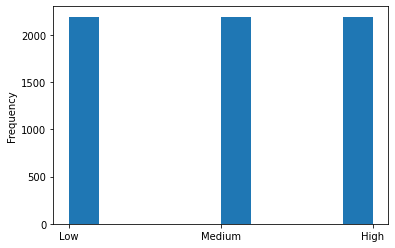

In [ ]:
plt.hist(y_over)
plt.xticks([1,2,3],['Low','Medium','High'])
plt.ylabel('Frequency')
plt.show()

# Train models

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, cohen_kappa_score, accuracy_score

def print_metrics(y_test, y_pred):
  acc = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred,average="weighted")
  recall = recall_score(y_test, y_pred,average="weighted")
  f1 =  f1_score(y_test, y_pred,average="weighted")
  kappa = cohen_kappa_score(y_test, y_pred, weights="quadratic")
  return [np.round(x,2) for x in [acc,precision,recall,f1,kappa]]

**Model 1:** Random Forest

In [ ]:
# train
rf = RandomForestClassifier()
rf_model = rf.fit(X_over, y_over)
# performance
y_pred = rf_model.predict(X_test)
rf_model_simple = print_metrics(y_test, y_pred)
print(rf_model_simple)
print(classification_report(y_test, y_pred))

[0.71, 0.73, 0.71, 0.71, 0.6]
              precision    recall  f1-score   support

           1       0.87      0.51      0.64       106
           2       0.67      0.85      0.75       510
           3       0.76      0.59      0.66       384

    accuracy                           0.71      1000
   macro avg       0.77      0.65      0.69      1000
weighted avg       0.73      0.71      0.71      1000



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


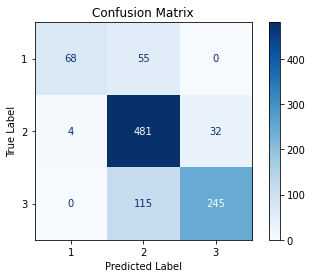

In [ ]:
from sklearn.metrics import plot_confusion_matrix
 
color = 'black'
matrix = plot_confusion_matrix(rf_model, X_test, y_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

Feature importance

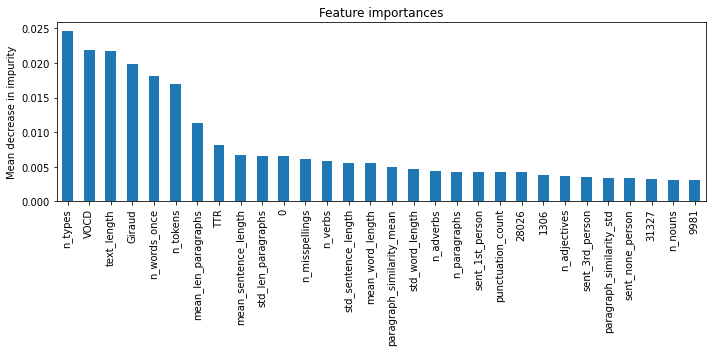

In [ ]:
import matplotlib.pyplot as plt
importances = rf_model.feature_importances_
std = np.std([rf_model.feature_importances_ for tree in rf_model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=[x for x in data_model2.drop(columns=['cluster_label']) if x!= 'label'])
forest_importances.sort_values(ascending=False,inplace=True)
fig, ax = plt.subplots(figsize = (10,5))
forest_importances[:30].plot.bar(yerr=std[:30], ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

**Model 2:** SVM

[0.63, 0.64, 0.63, 0.63, 0.57]
              precision    recall  f1-score   support

           1       0.58      0.73      0.65       123
           2       0.67      0.60      0.64       517
           3       0.61      0.65      0.63       360

    accuracy                           0.63      1000
   macro avg       0.62      0.66      0.64      1000
weighted avg       0.64      0.63      0.63      1000



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


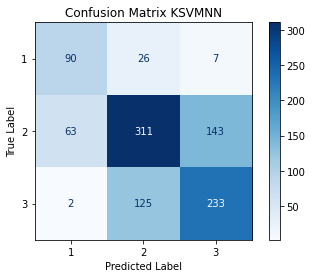

In [ ]:
from sklearn import svm
svm_model = svm.SVC()
svm_model.fit(X_over, y_over)
# performance
y_pred = svm_model.predict(X_test)
svm_model_simple = print_metrics(y_test, y_pred)
print(svm_model_simple)
print(classification_report(y_test, y_pred))

matrix = plot_confusion_matrix(svm_model, X_test, y_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix KSVMNN', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

**Model 3:** KNN

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


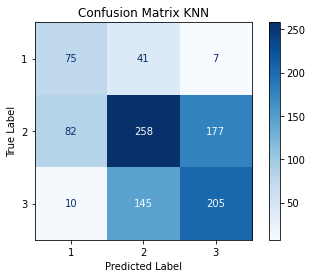

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_over, y_over)
# performance
y_pred = neigh.predict(X_test)
knn_model_simple = print_metrics(y_test, y_pred)
print(knn_model_simple)
rint(classification_report(y_test, y_pred))

matrix = plot_confusion_matrix(neigh, X_test, y_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix KNN', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

Model 4: LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)
target_names = ['High','Medium','Low']
print(classification_report(y_test, y_pred)) 

# Clustering: elbow method

Initially planned for improving model performance, but it was finally discarded due to data leakage.

1
1


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


2


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


3


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


4


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


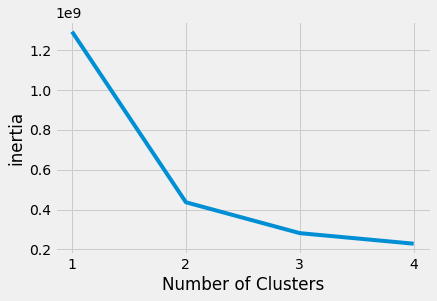

2
1


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


2


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


3


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


4


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


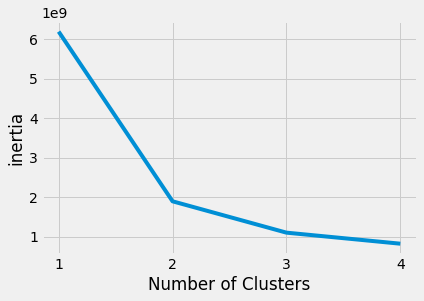

3
1


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


2


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


3


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


4


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


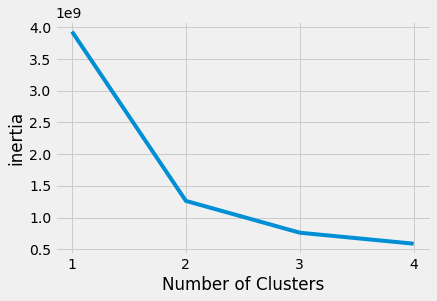

In [ ]:
from ssl import SSL_ERROR_INVALID_ERROR_CODE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for label in [1,2,3]:
  print(label)
  data_clust = data_model[data_model.label == label] #.drop(columns=['label', 'text','text_'])

  sse = []
  for k in range(1, 5):
    print(k)
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_clust)
    sse.append(kmeans.inertia_)

  plt.style.use("fivethirtyeight")
  plt.plot(range(1, 5), sse)
  plt.xticks(range(1, 5))
  plt.xlabel("Number of Clusters")
  plt.ylabel("inertia")
  plt.show()